Take a copy of this notebook for each model you will implement.

This is the initial notebook — any changes will be made here before starting model building to ensure consistency across all notebooks.

**Key Consistency Tips**

* Standardized Headings: Use identical section names across all notebooks.

* Code Comments: Explain non-trivial steps (e.g., "Handling class imbalance with SMOTE").

* Version Control: Add a requirements.txt in the repo for dependency management. مش لازم

* Outputs: Save all plots/figures to a /results folder with consistent naming (e.g., XGBoost_SHAP.png).
اعتقد هتبقى كويسة عشان واحنا بنعمل البيبر ما نقعدش ناخد سكرينات


* Reproducibility: Set global random seeds (e.g., np.random.seed(42)).

# **Imports**

In [ ]:
%%capture
!pip install -q lime shap

In [ ]:
# Import model-specific libraries (e.g., sklearn, XGBoost, SHAP)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

# **Utils**

In [ ]:
def our_confusion_matrix(model, name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap="Oranges", ax=ax1)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Oranges", ax=ax2)
    plt.title(f"{name} Confusion Matrix")

def our_roc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(
    model, X_train, y_train,
    name=name, ax=ax1,
    color="orange"
    )
    roc2 = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name, ax=ax2,
        color="orange"
    )
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="orange")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)

def our_learning_curve(model, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )

    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)

def our_prc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='orange')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='orange')

# **Load Processed Dat**a

In [ ]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/processed_IBM_dataset.csv")
df

Age  BusinessTravel  DailyRate  Department  DistanceFromHome  Education  \
0      41               2       1102           2                 1          2   
1      49               1        279           1                 8          1   
2      37               2       1373           1                 2          2   
3      33               1       1392           1                 3          4   
4      27               2        591           1                 2          1   
...   ...             ...        ...         ...               ...        ...   
1465   36               1        884           1                23          2   
1466   39               2        613           1                 6          1   
1467   27               2        155           1                 4          3   
1468   49               1       1023           2                 2          3   
1469   34               2        628           1                 8          3   

      EducationField  EnvironmentSatisfaction  Gender  HourlyRate  ...  \
0                  1                        2       0          94  ...   
1                  1                        3       1          61  ...   
2                  4                        4       1          92  ...   
3                  1                        4       0          56  ...   
4                  3                        1       1          40  ...   
...              ...                      ...     ...         ...  ...   
1465               3                        3       1          41  ...   
1466               3                        4       1          42  ...   
1467               1                        2       1          87  ...   
1468               3                        4       1          63  ...   
1469               3                        2       1          82  ...   

      TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
0                         0                1               6   
1                         3                3              10   
2                         3                3               0   
3                         3                3               8   
4                         3                3               2   
...                     ...              ...             ...   
1465                      3                3               5   
1466                      5                3               7   
1467                      0                3               6   
1468                      3                2               9   
1469                      3                4               4   

      YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  \
0                      4                        0                     5   
1                      7                        1                     7   
2                      0                        0                     0   
3                      7                        3                     0   
4                      2                        2                     2   
...                  ...                      ...                   ...   
1465                   2                        0                     3   
1466                   7                        1                     7   
1467                   2                        0                     3   
1468                   6                        0                     8   
1469                   3                        1                     2   

      promotion_velocity  workload_score  compensation_ratio  Attrition  
0          600000.000000               7            0.961804          1  
1               9.999900               1            1.776623          0  
2               0.000000               5            0.724186          1  
3               2.666658               5            1.007446          0  
4               0.999995               1            1.201663          0  
...                  ...      

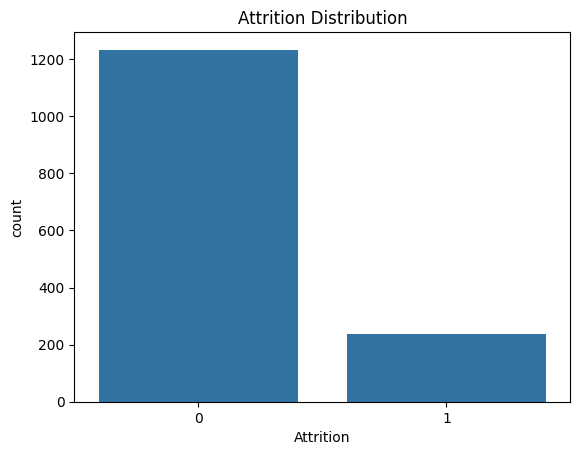

In [ ]:
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

In [ ]:
X = df.drop('Attrition', axis=1)
y = df.Attrition

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1102, 33), (368, 33), (1102,), (368,))

In [ ]:
feature_names  = list(X_train.columns)

# **Preprocessing**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

# **Model Initialization**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNeighborsClassifier().fit(X_train, y_train).score(X_test, y_test)

0.845108695652174

# **Model Training**

In [ ]:
train_acc, test_acc = [], []
for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    test_acc.append(knn.score(X_test, y_test))


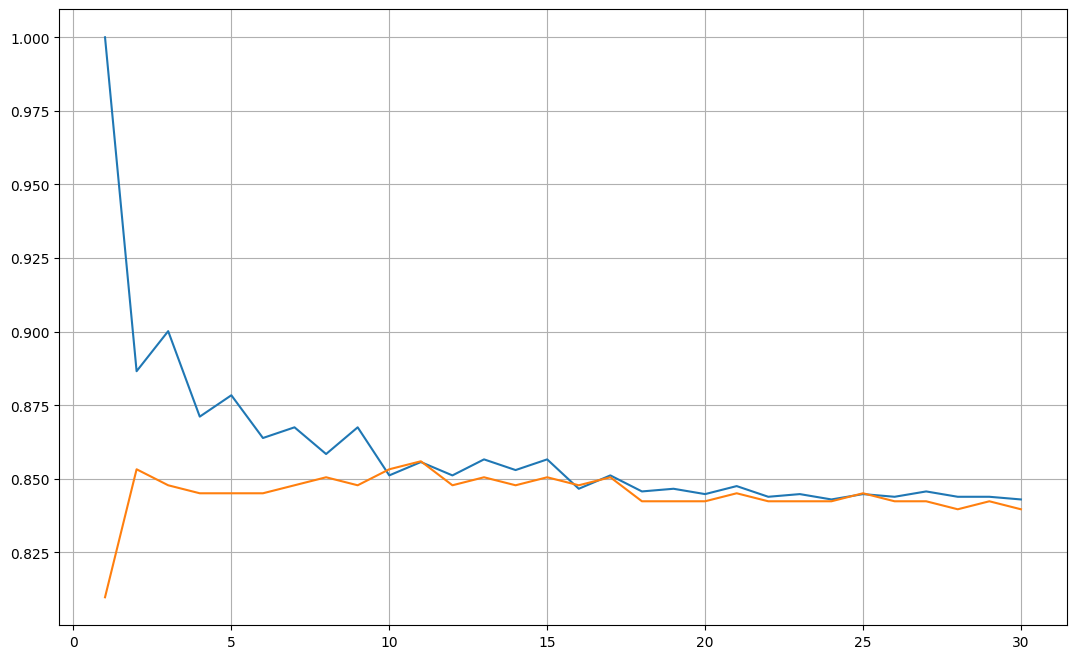

In [ ]:
plt.figure(figsize=(13, 8))
plt.plot(range(1, 31), train_acc)
plt.plot(range(1, 31), test_acc)
plt.grid()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train).score(X_test, y_test)

0.8559782608695652

# **Model Evaluation**

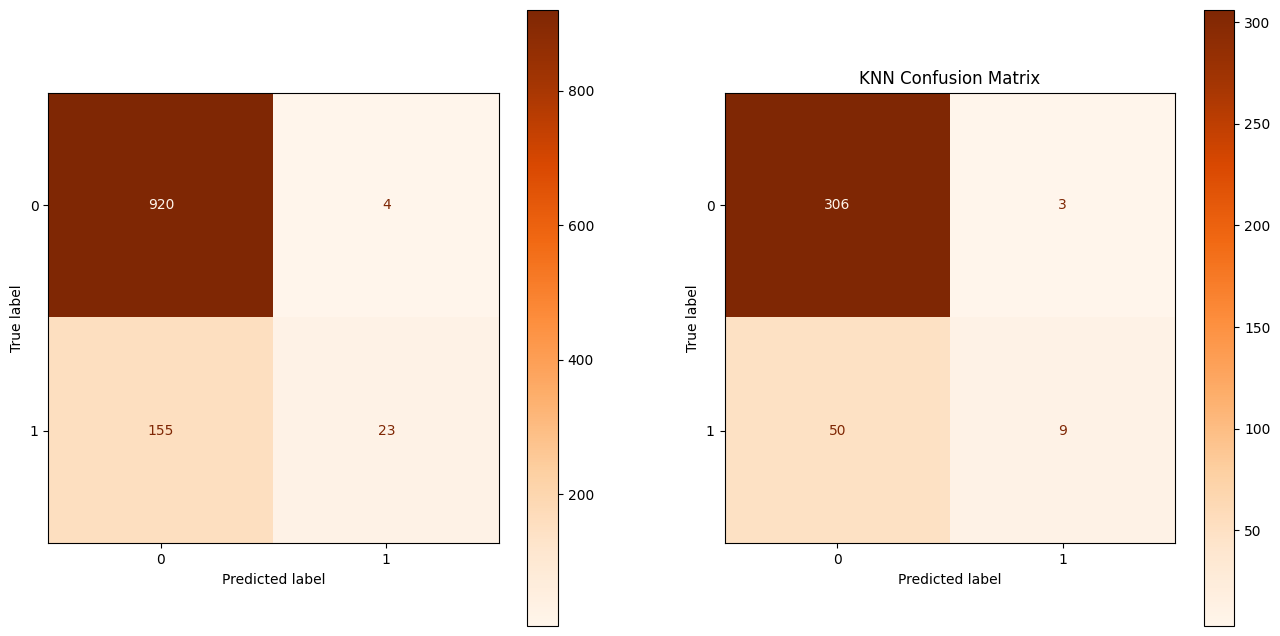

In [ ]:
our_confusion_matrix(knn, "KNN")

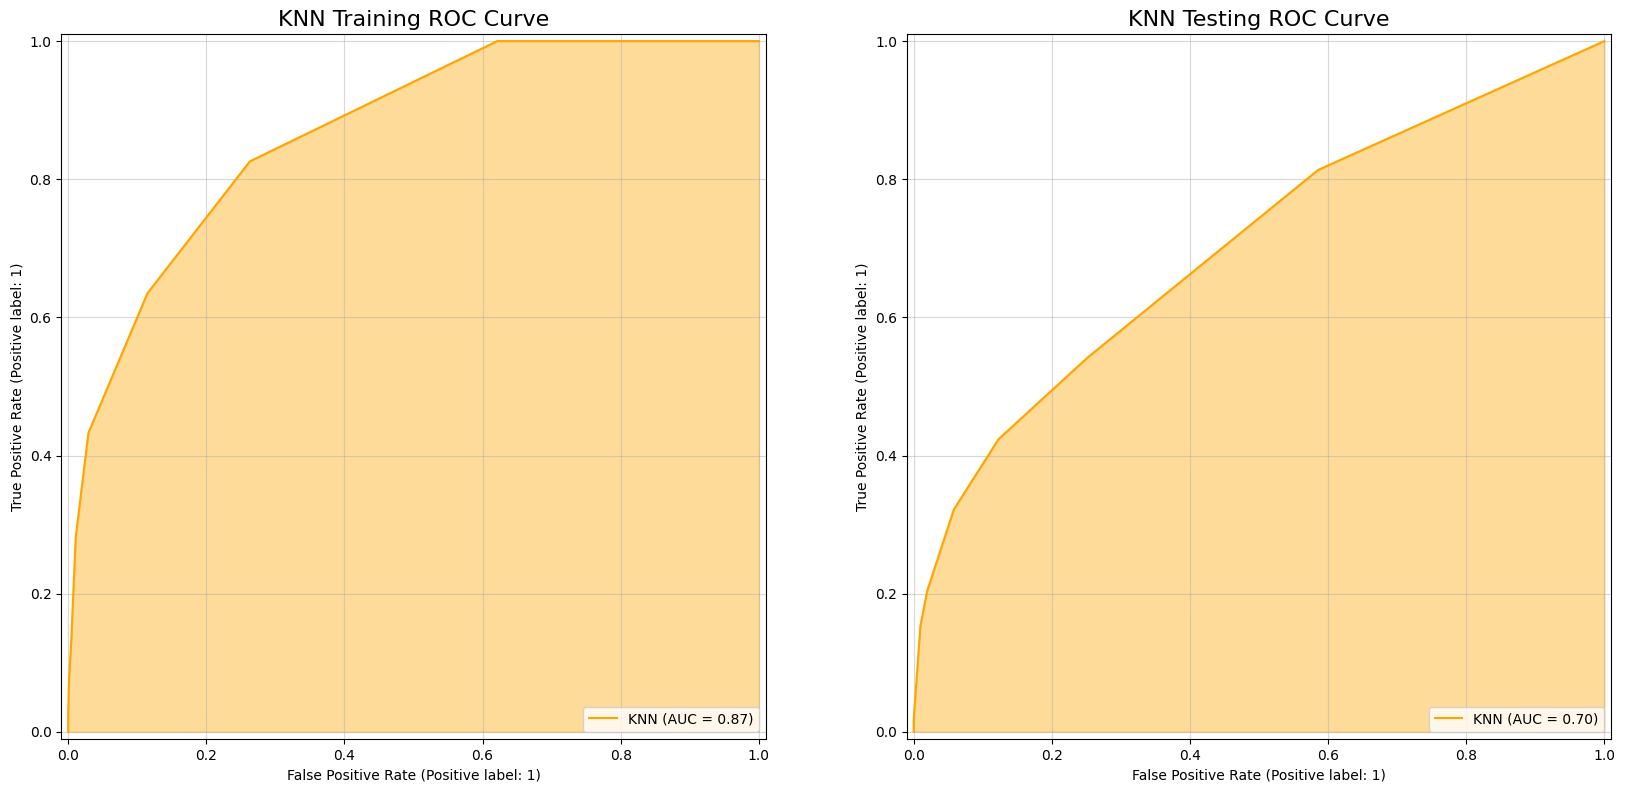

In [ ]:
our_roc(knn, "KNN")

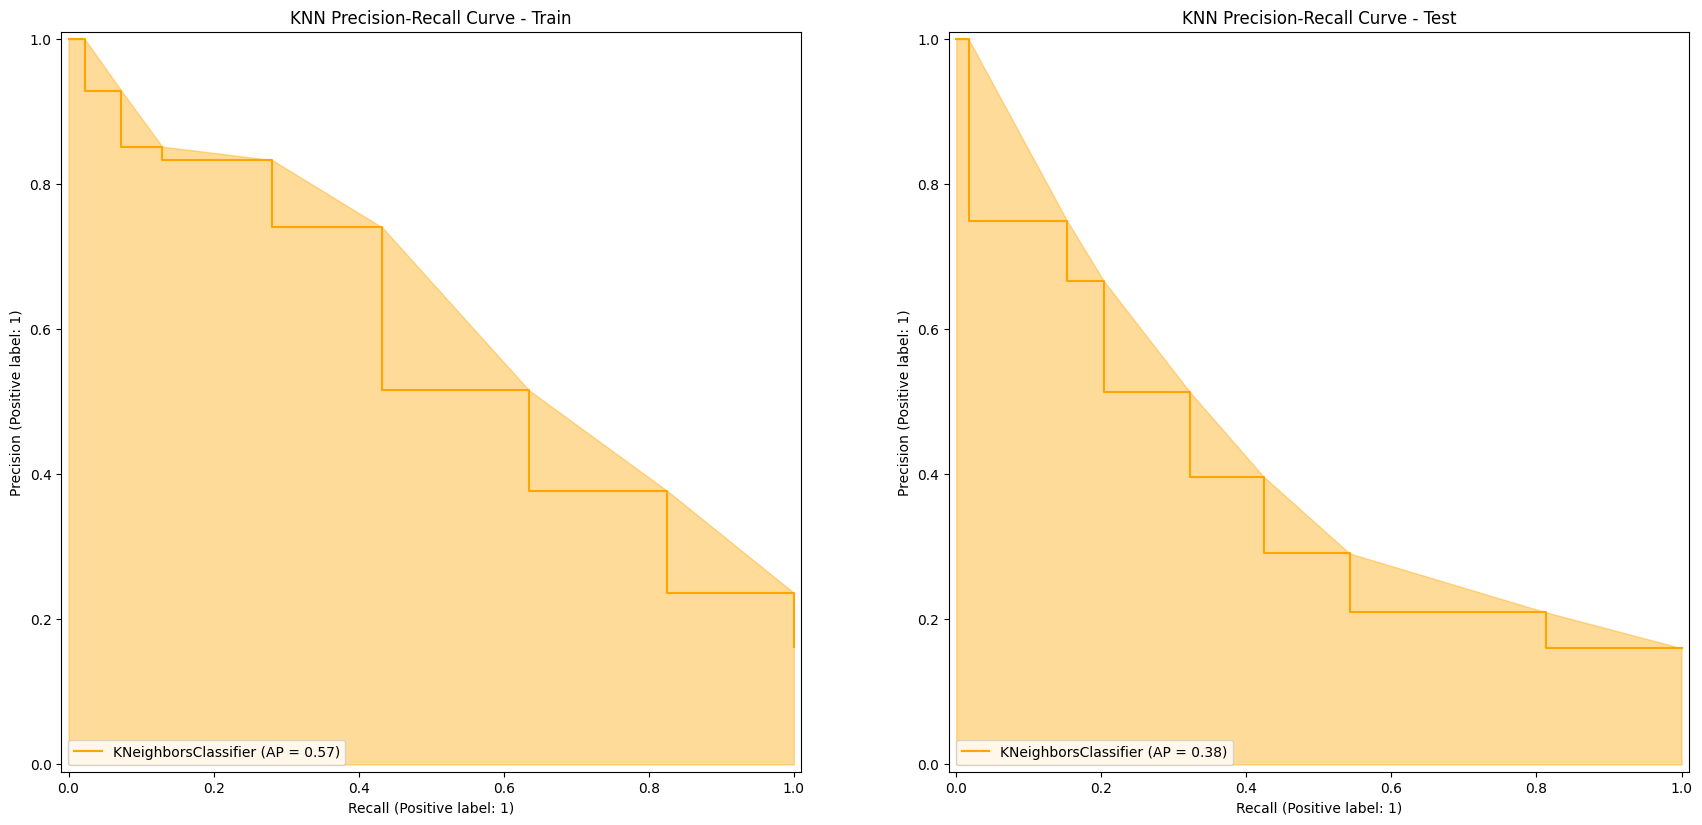

In [ ]:
our_prc(knn, "KNN")

# **Explainability Techniques**

## Feature Importance (Model-Specific)

Text(0.5, 1.0, 'KNN Feature Importances (Permutation)')

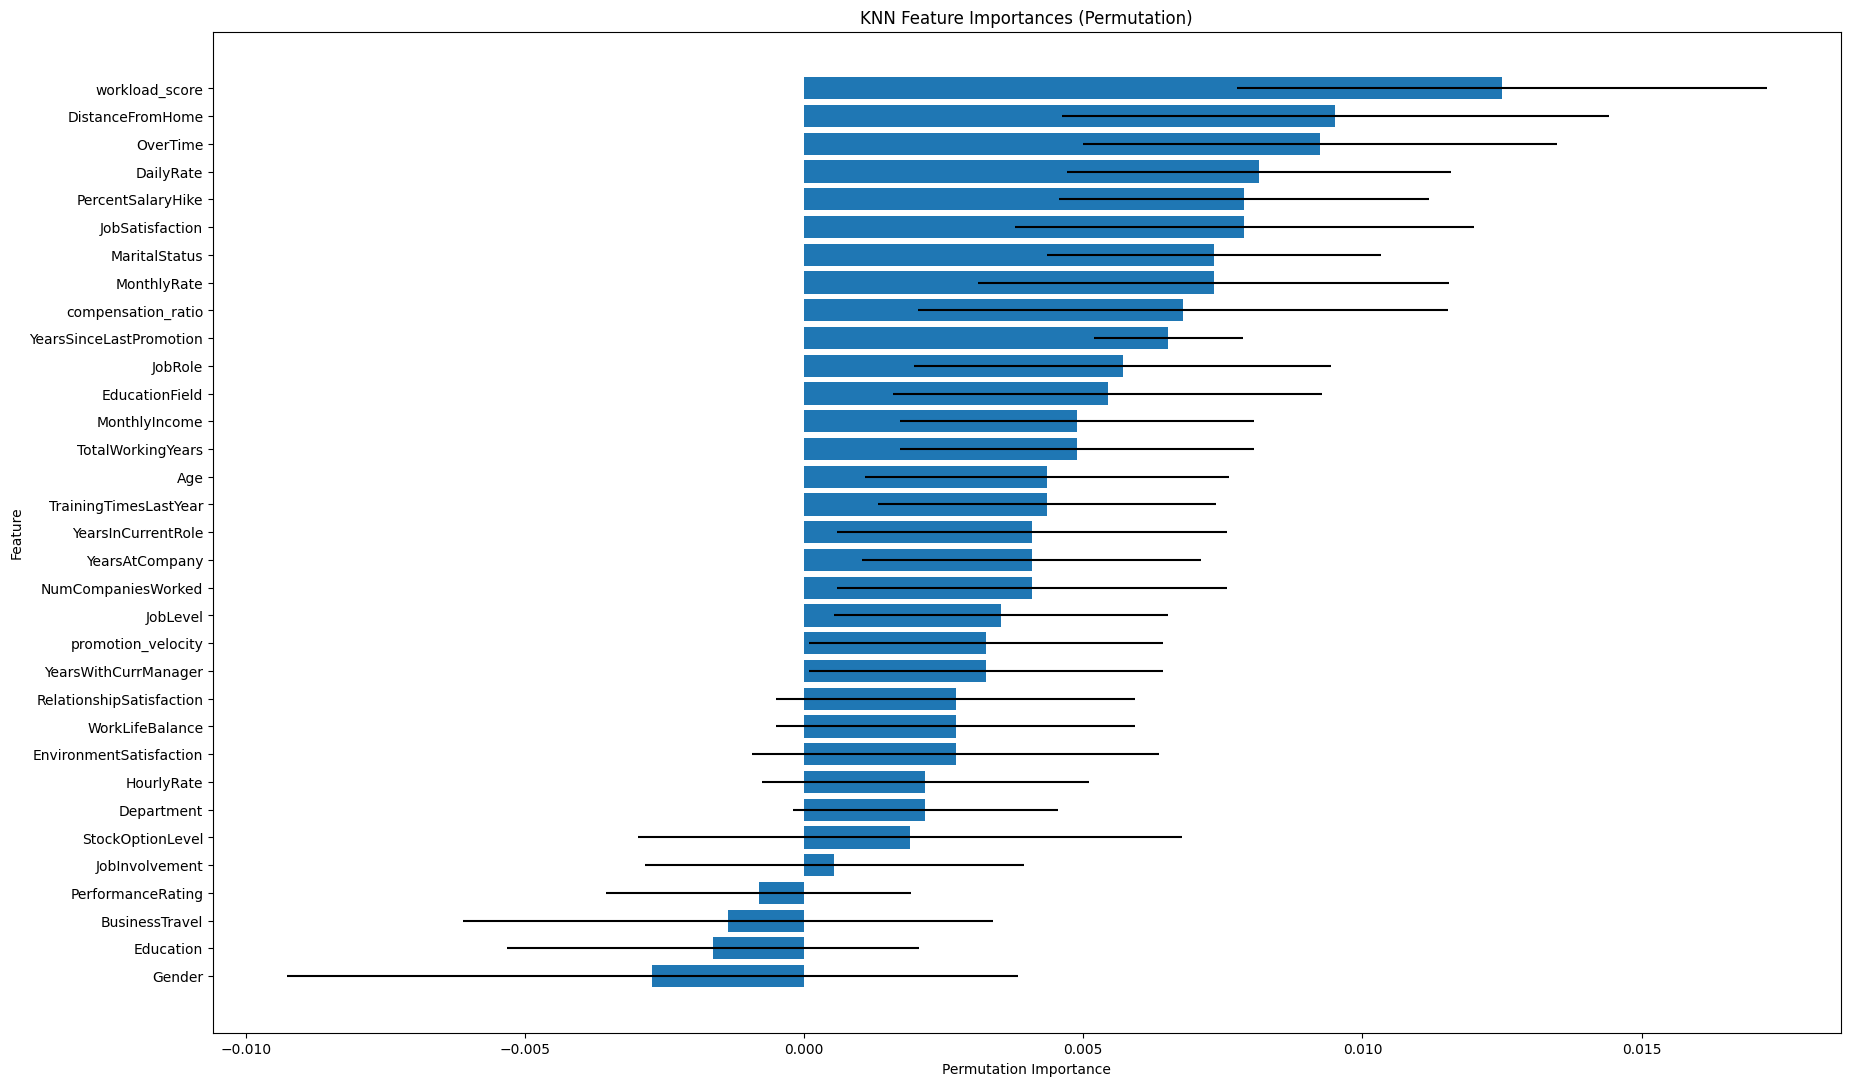

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
importances = r.importances_mean
stds = r.importances_std
indices = np.argsort(importances)
plt.figure(figsize=(21, 13))
plt.barh(range(len(indices)), importances[indices], xerr=stds[indices], align='center')
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("KNN Feature Importances (Permutation)")

## Partial Dependence Plots

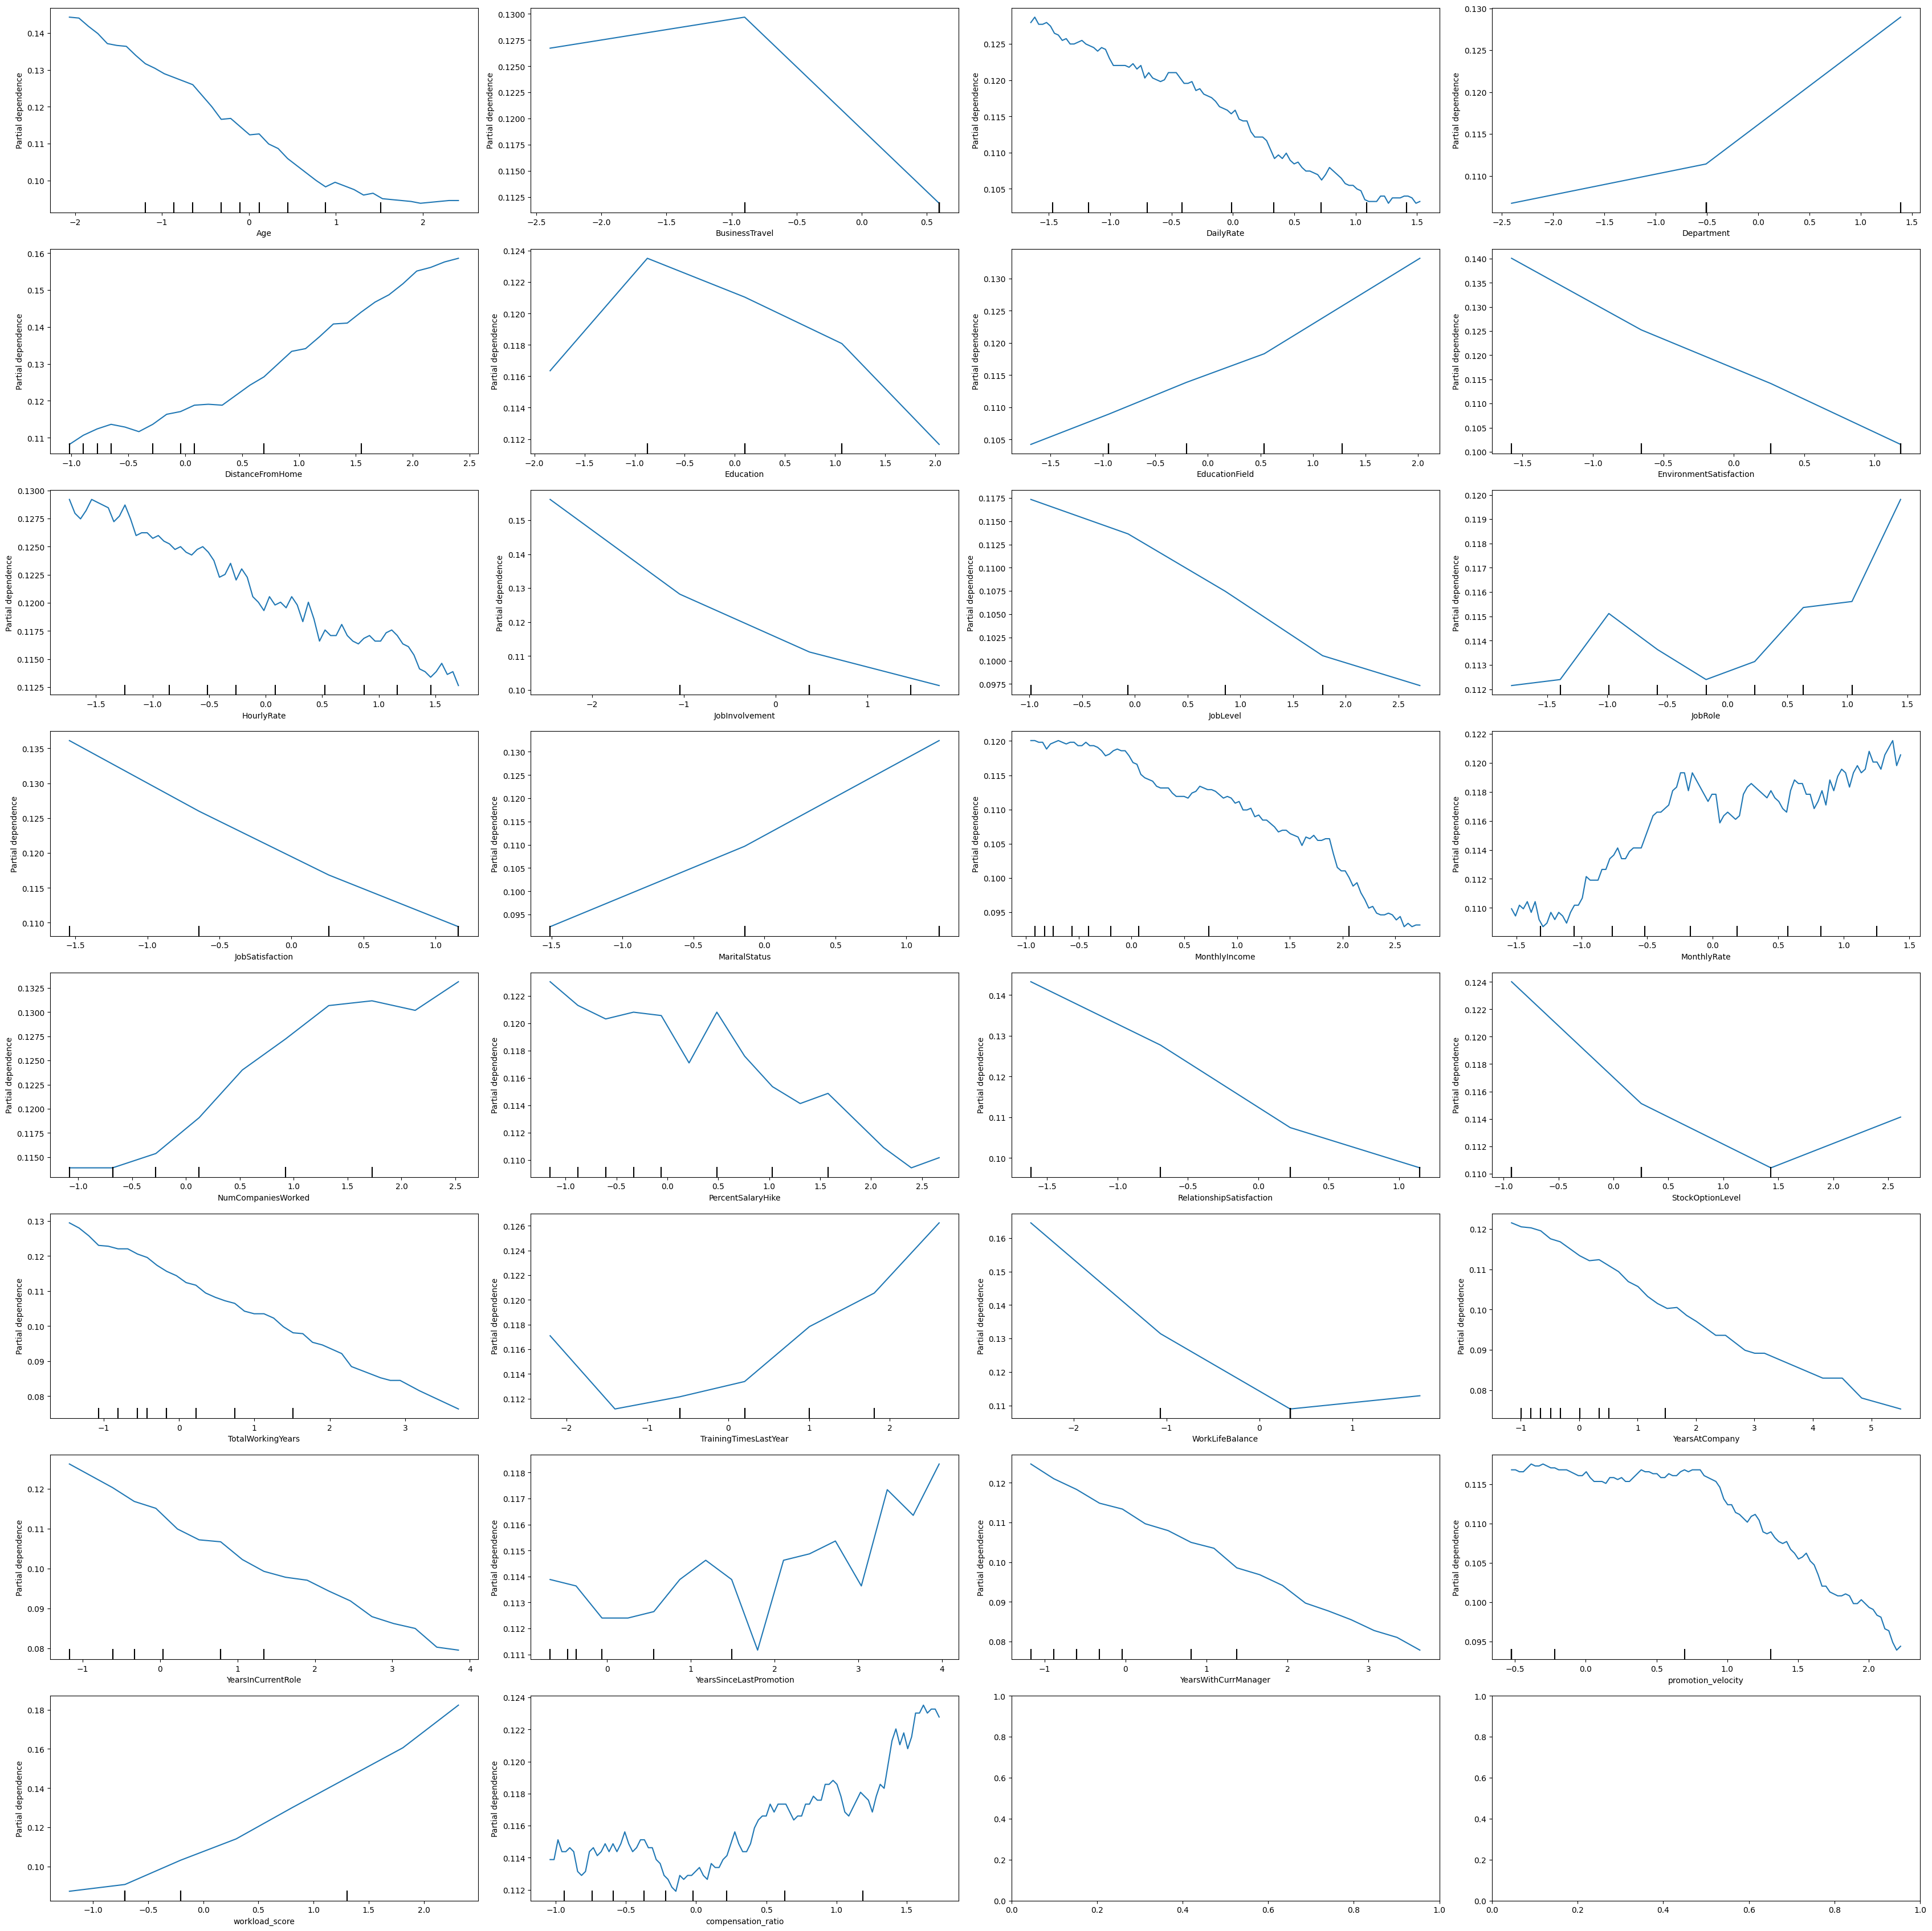

In [ ]:
cols = [c for c in X_test.columns if X_test[c].nunique()>2]
nc = 4
nr = (len(cols) + nc - 1) // nc
fig, axes = plt.subplots(nr, nc, figsize=(30, 30))
for ax, feat in zip(axes.flatten(), cols):
    PartialDependenceDisplay.from_estimator(
        knn, X_test, [feat], ax=ax)
plt.tight_layout()

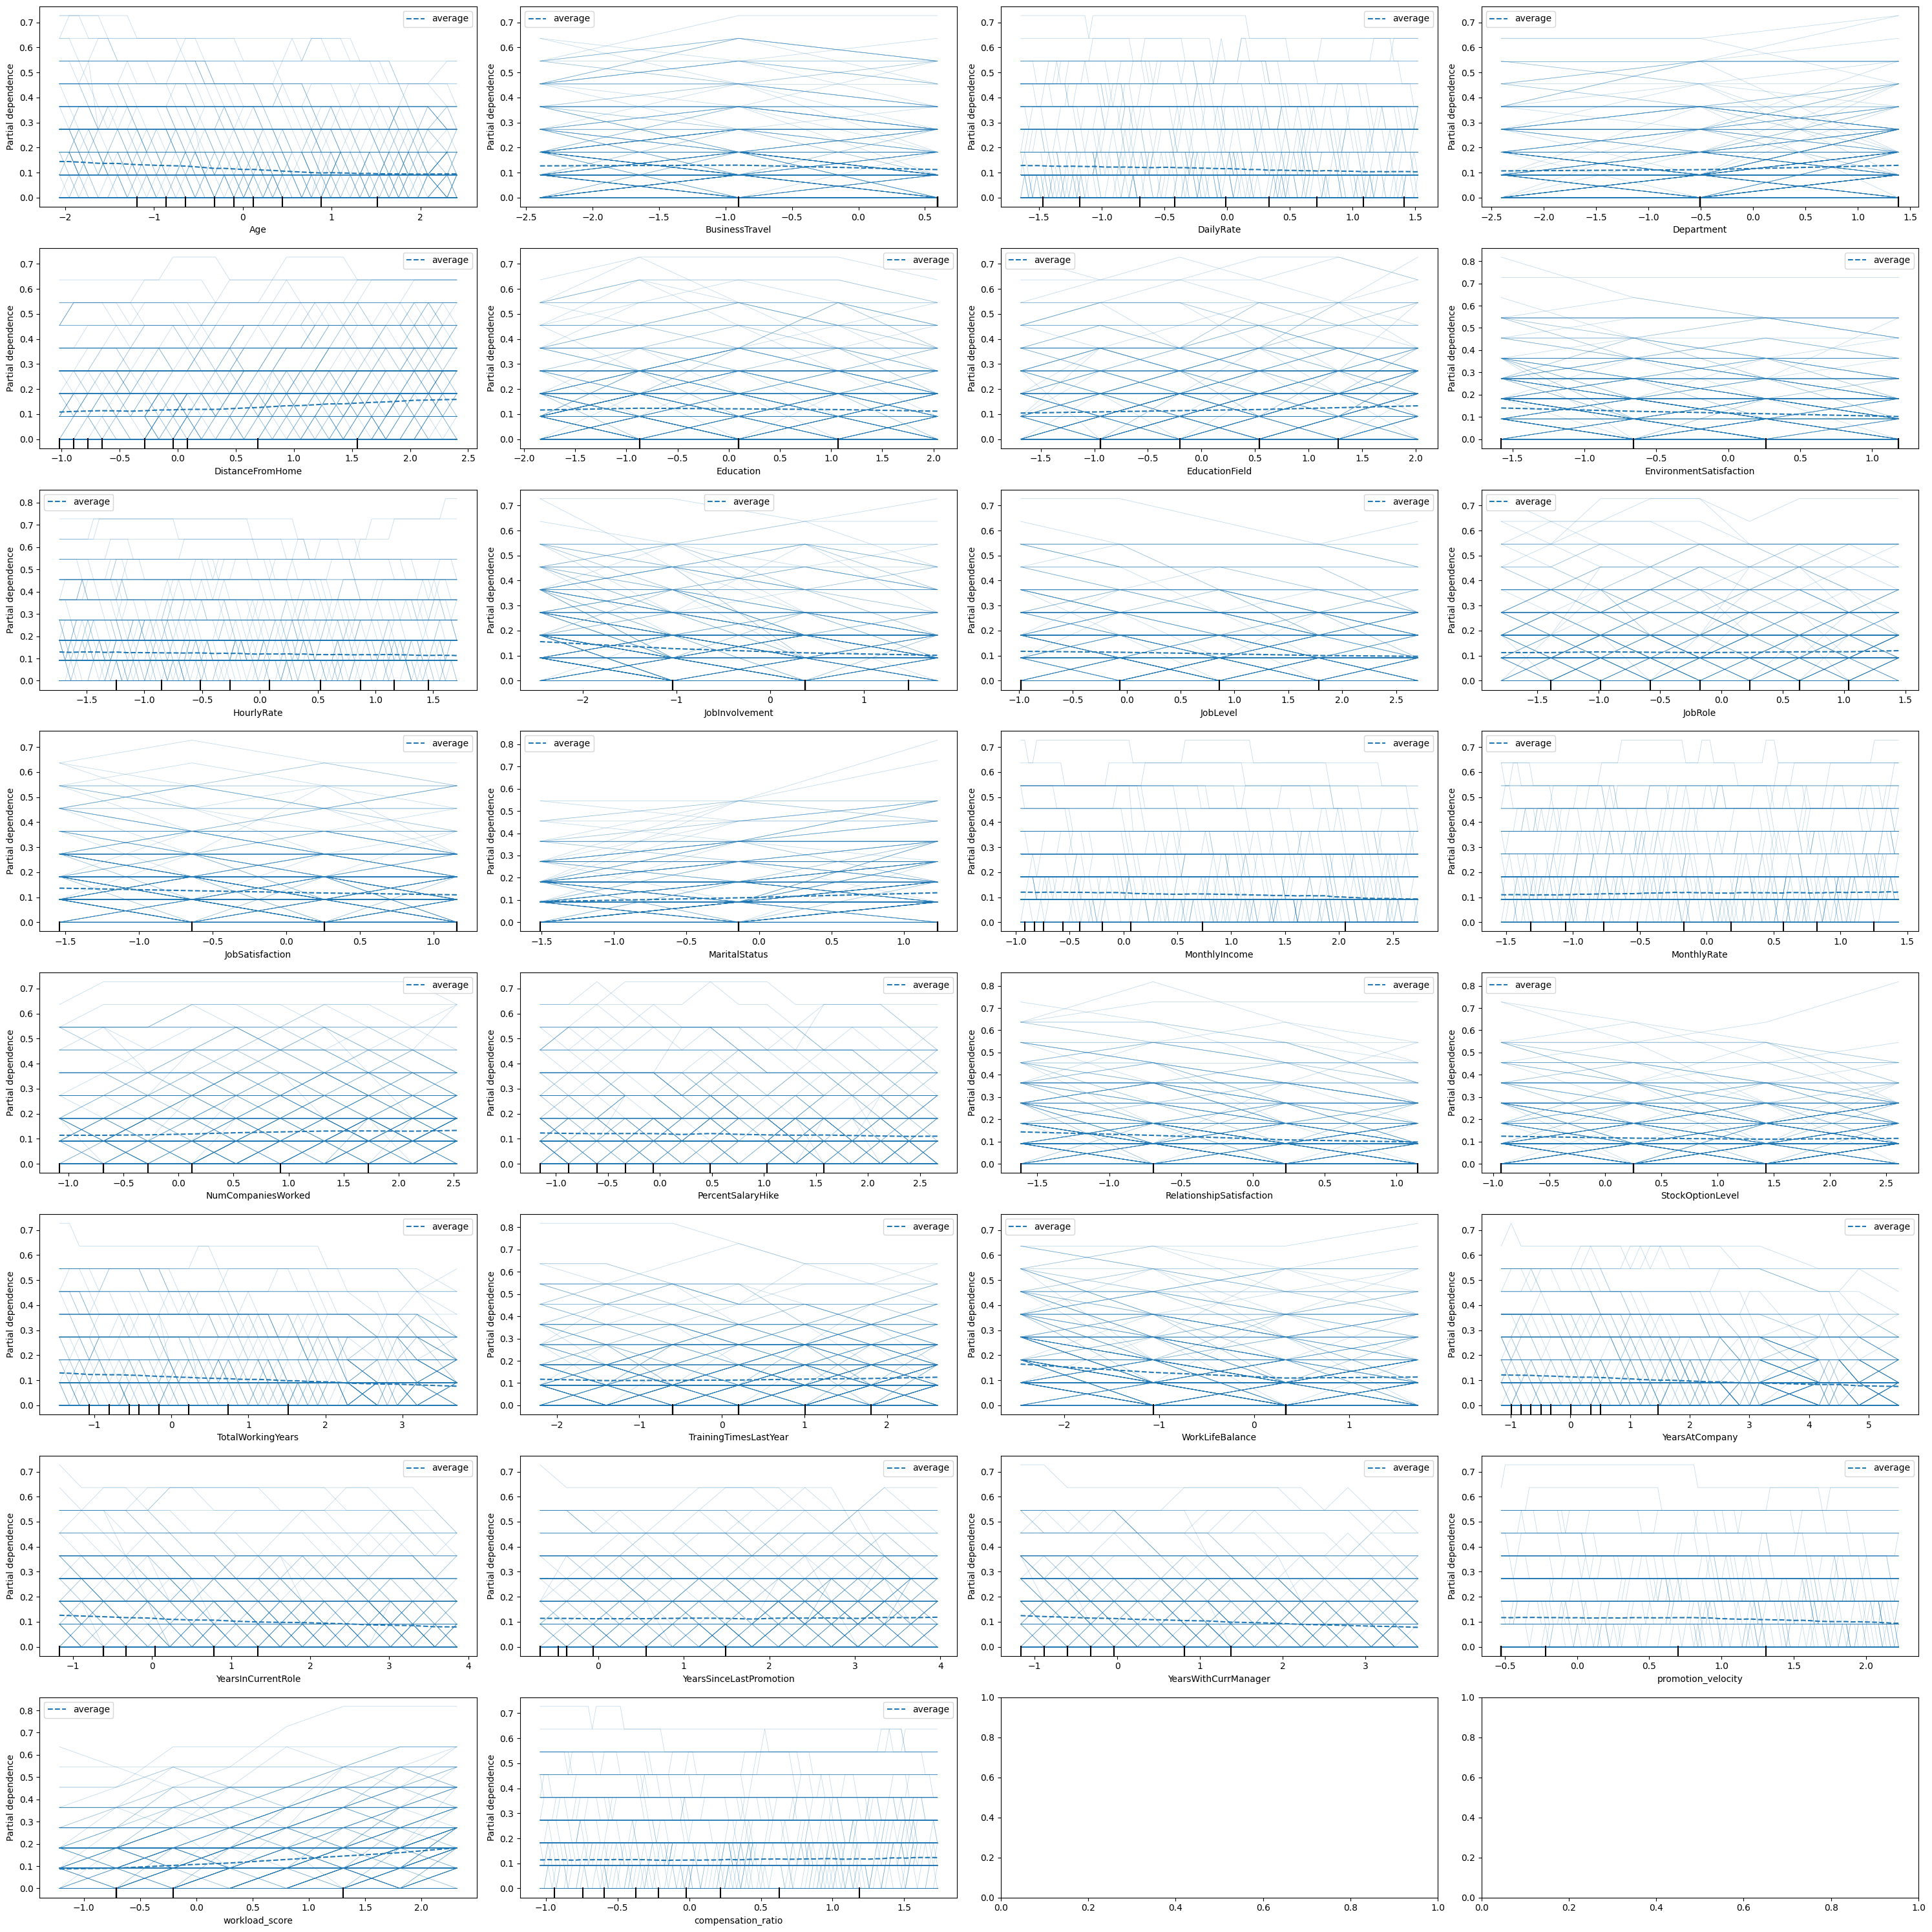

In [ ]:
cols = [c for c in X_test.columns if X_test[c].nunique()>2]
nc = 4
nr = (len(cols) + nc - 1) // nc
fig, axes = plt.subplots(nr, nc, figsize=(30, 30))
for ax, feat in zip(axes.flatten(), cols):
    PartialDependenceDisplay.from_estimator(
        knn, X_test, [feat], ax=ax, kind='both')
plt.tight_layout()

## LIME Analysis

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
class_names = ['Attrition', 'No Attrition']
feature_names = list(X_train.columns)
explainer = LimeTabularExplainer(X_train.values, feature_names =
                                 feature_names,
                                 class_names = class_names,
                                 mode = 'classification')
exp = explainer.explain_instance(
    X_test.values[1],
    knn.predict_proba,
    num_features=len(feature_names)
)
exp.show_in_notebook(show_table=True)

## SHAP Analysis

In [ ]:
import shap
explainer = shap.KernelExplainer(knn.predict_proba, X_test[:100])
shap_values = explainer.shap_values(X_test[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

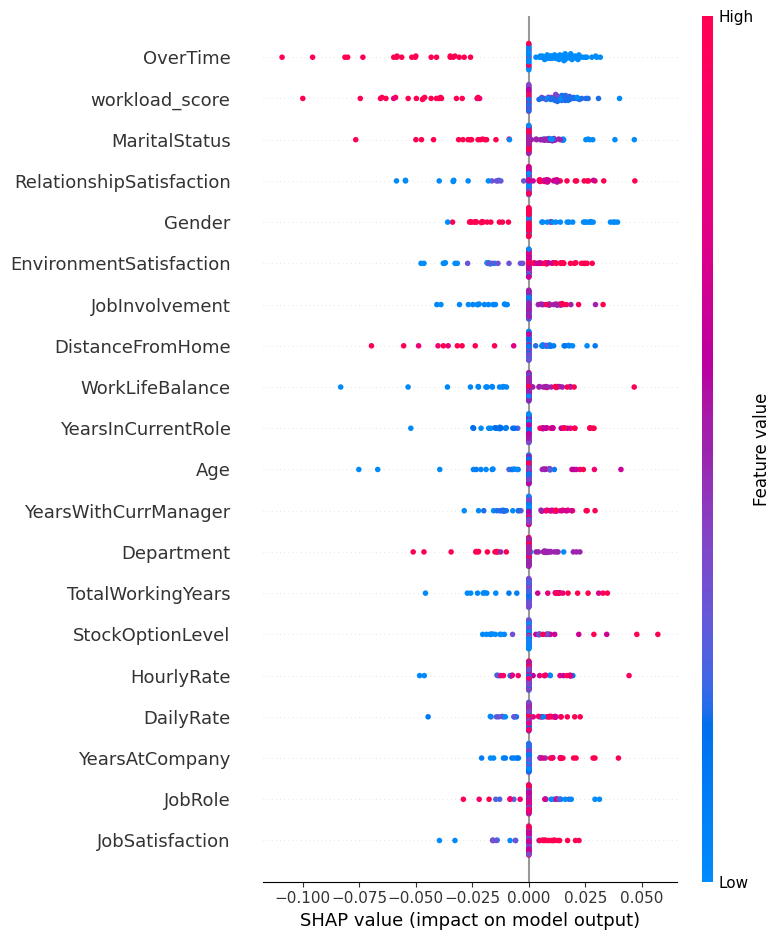

In [ ]:
shap.summary_plot(shap_values[:, :, 0], X_test[:100])

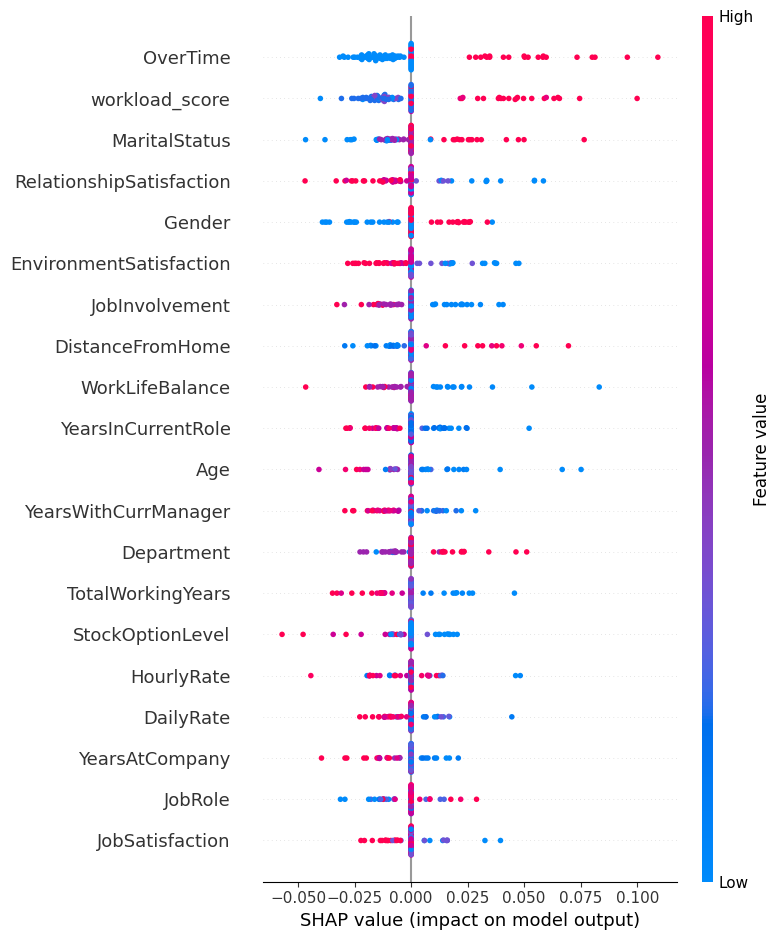

In [ ]:
shap.summary_plot(shap_values[:, :, 1], X_test[:100])

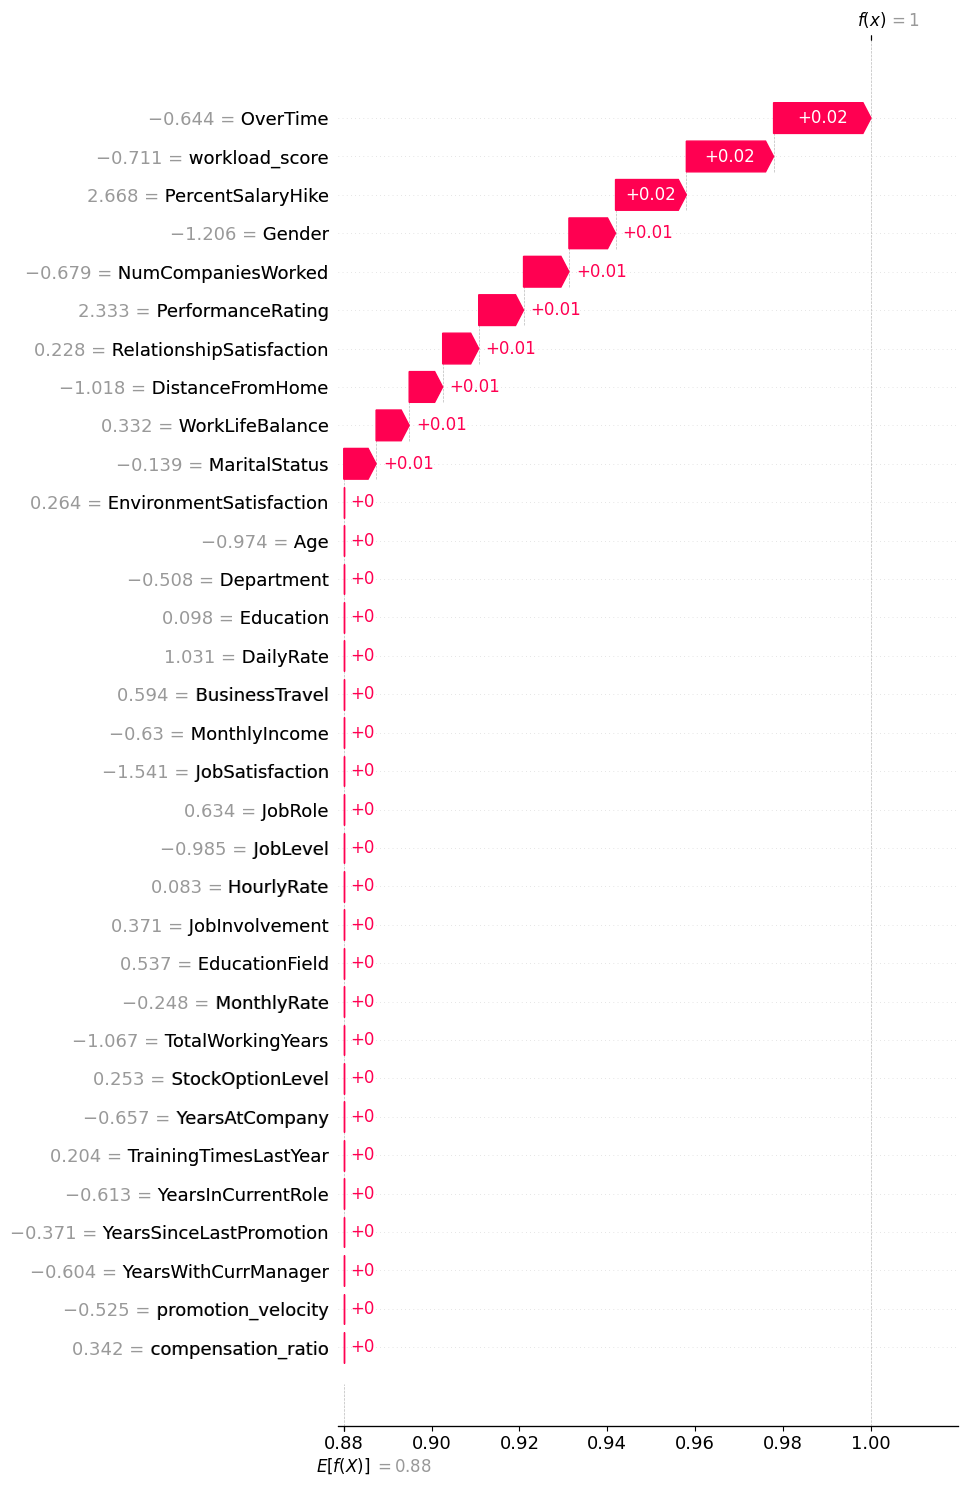

In [ ]:
shap_values_exp = shap.Explanation(
    values=shap_values[0][:, 0],
    base_values=explainer.expected_value[0],
    data=X_test.iloc[0],
    feature_names=X_test.columns
)

shap.waterfall_plot(shap_values_exp, max_display=len(X_test.columns))